In [16]:
import pandas as pd
import numpy as np
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, mean_squared_error
from bayes_opt import BayesianOptimization
import seaborn as sns
import matplotlib.pyplot as plt

e:\Bootcamp\Titanic Spaceship\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargamos el archivo y comprobamos que los datos efectivamente están limpios

In [2]:
df = pd.read_csv('Train_recoded.csv')
df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
VIP             0
Name            0
Transported     0
Algun_Gasto     0
CabinDeck       0
CabinSide       0
Group           0
GroupNumber     0
Last Name       0
Solo            0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Gastos          0
CabinNumber     0
GroupSize       0
AgeGroup        0
dtype: int64

Recoficamos las variables categóricas en numéricas asignandoles valores numéricos en orden (0, 1, 2...)

In [3]:
df.loc[:, 'HomePlanet'] = df['HomePlanet'].map({'Europa': 0, 'Earth': 1, 'Mars': 2}).astype(int)
df.loc[:, 'CabinDeck'] = df['CabinDeck'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}).astype(int)
df.loc[:, 'CabinSide'] = df['CabinSide'].map({'P': 0, 'S': 1})
df.loc[:, 'CryoSleep'] = df['CryoSleep'].astype(int)
df.loc[:, 'Destination'] = df['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}).astype(int)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_19144\2690992866.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, 'CryoSleep'] = df['CryoSleep'].astype(int)


Separamos los conjuntos de entrenamiento y test, se eliminan además aquellas columnas que no vayan a usarse para el entrenamiento.

In [4]:
columnas_no_usadas = ["PassengerId", "Name", "Last Name", "Cabin"]

df = df.drop(columns = columnas_no_usadas)

y = df['Transported']
X = df.drop(['Transported'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [5]:

def gbc_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf, subsample, learning_rate):
    model = GradientBoostingClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        subsample=subsample,
        learning_rate=learning_rate,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy  # Queremos minimizar el MSE

# Definir los límites de los hiperparámetros a optimizar
pbounds = {
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'subsample': (0.1, 1),
    'learning_rate': (0.01, 0.3),
}

# Optimización Bayesiana
optimizer = BayesianOptimization(
    f=gbc_evaluate,
    pbounds=pbounds,
    random_state=42,
)

# Aumentar el número de iteraciones para maximizar la búsqueda
optimizer.maximize(init_points=5, n_iter=100)

# Una vez que la búsqueda ha terminado, obtenemos los mejores parámetros
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

# Entrenar el modelo final con los mejores parámetros
final_model = GradientBoostingClassifier(
    **best_params,
    random_state=42
)

final_model.fit(X_train, y_train)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7863    | 0.1186    | 9.655     | 14.91     | 12.78     | 89.0      | 0.2404    |
| 2         | 0.7901    | 0.02684   | 9.063     | 12.42     | 14.75     | 55.15     | 0.9729    |
| 3         | 0.778     | 0.2514    | 4.486     | 4.455     | 5.301     | 126.1     | 0.5723    |
| 4         | 0.7809    | 0.1353    | 5.039     | 12.63     | 4.511     | 123.0     | 0.4297    |
| 5         | 0.763     | 0.1423    | 8.496     | 4.794     | 11.26     | 198.1     | 0.1418    |
| 6         | 0.7755    | 0.3       | 3.0       | 20.0      | 2.0       | 300.0     | 0.1911    |
| 7         | 0.8017    | 0.01942   | 4.507     | 2.168     | 3.579     | 289.3     | 0.5095    |
| 8         | 0.7934    | 0.09859   | 8.025     | 13.16     | 14.28     | 55.79     | 0.548     |
| 9         | 0.793 

GradientBoostingClassifier(learning_rate=0.01, max_depth=9, min_samples_leaf=8,
                           min_samples_split=16, n_estimators=280,
                           random_state=42, subsample=0.1)

Sacamos los resultados de accuracy, validación cruzada y pintamos los gráficos de curva roc y matriz de confusión

In [6]:
y_pred = final_model.predict(X_test)

# Validación cruzada
cv_scores = cross_val_score(final_model, X, y, cv=5)

print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

Puntajes de validación cruzada: [0.68019988 0.734375   0.788125   0.81375    0.783125  ]
Media de los puntajes: 0.7599149750156153


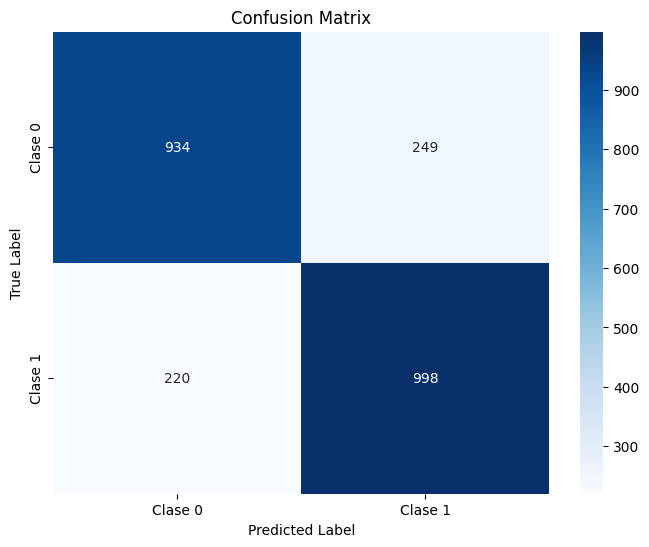

Precisión del modelo: 0.8046647230320699
Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.81      0.79      0.80      1183
        True       0.80      0.82      0.81      1218

    accuracy                           0.80      2401
   macro avg       0.80      0.80      0.80      2401
weighted avg       0.80      0.80      0.80      2401



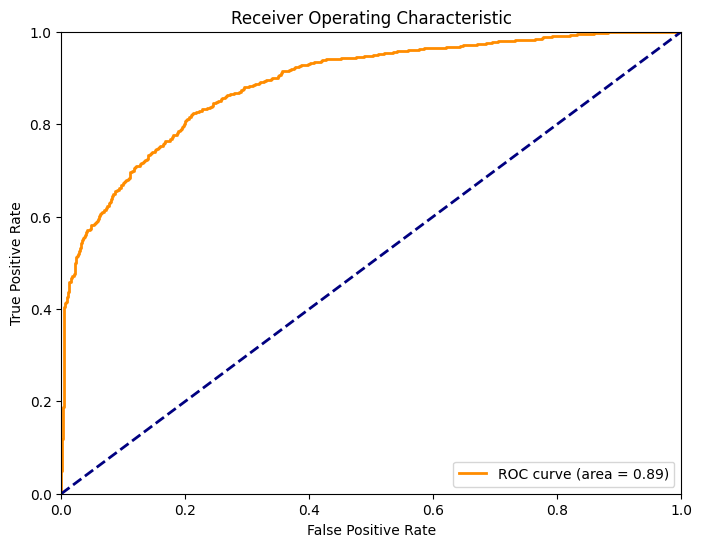

In [7]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(f"Precisión del modelo: {accuracy}")
print("Reporte de clasificación:\n", class_report)

# Calcular y graficar la curva ROC
y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Podemos hacer también un análisis de las features que hemos incluido en el modelo para comprobar si puede suprimirse alguna que no aporte al modelo.

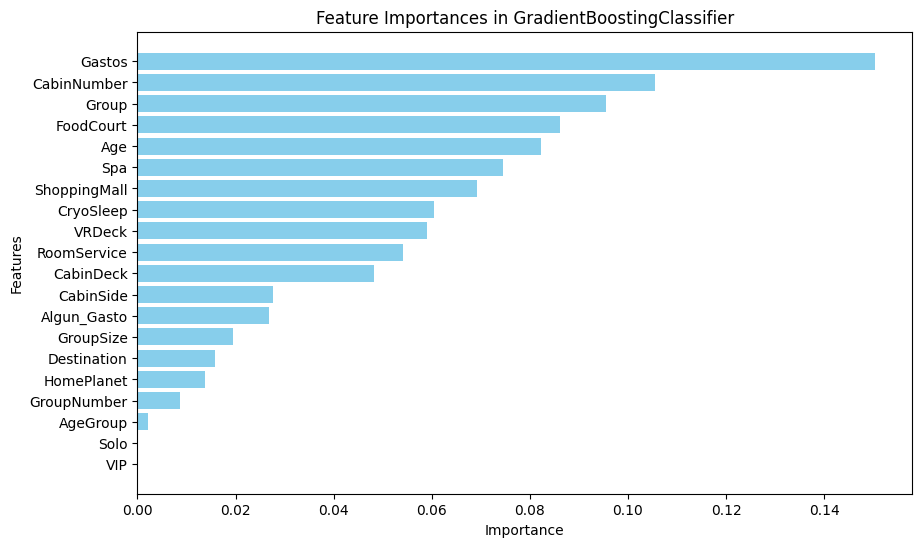

In [8]:
feature_importance = final_model.feature_importances_

# Crear un DataFrame para visualizarlo mejor (asumiendo que tienes los nombres de las características)
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Ordenar de mayor a menor importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances in GradientBoostingClassifier')
plt.gca().invert_yaxis()  # Para que las características más importantes estén en la parte superior
plt.show()

Parece que la variable de Solo no esta aportando nada al modelo, y se podría valorar también la exclusión de la variable VIP. Reentrenamos el modelo con esas condiciones.

In [9]:
features_eliminadas = ['Solo', 'VIP']

y = df['Transported']
X = df.drop(features_eliminadas + ['Transported'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [10]:
def gbc_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf, subsample, learning_rate):
    model = GradientBoostingClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        subsample=subsample,
        learning_rate=learning_rate,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy  # Queremos minimizar el MSE

# Definir los límites de los hiperparámetros a optimizar
pbounds = {
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'subsample': (0.1, 1),
    'learning_rate': (0.01, 0.3),
}

# Optimización Bayesiana
optimizer = BayesianOptimization(
    f=gbc_evaluate,
    pbounds=pbounds,
    random_state=42,
)

# Aumentar el número de iteraciones para maximizar la búsqueda
optimizer.maximize(init_points=5, n_iter=100)

# Una vez que la búsqueda ha terminado, obtenemos los mejores parámetros
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

# Entrenar el modelo final con los mejores parámetros
final_model_2 = GradientBoostingClassifier(
    **best_params,
    random_state=42
)

final_model_2.fit(X_train, y_train)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7905    | 0.1186    | 9.655     | 14.91     | 12.78     | 89.0      | 0.2404    |
| 2         | 0.7909    | 0.02684   | 9.063     | 12.42     | 14.75     | 55.15     | 0.9729    |
| 3         | 0.7905    | 0.2514    | 4.486     | 4.455     | 5.301     | 126.1     | 0.5723    |
| 4         | 0.7963    | 0.1353    | 5.039     | 12.63     | 4.511     | 123.0     | 0.4297    |
| 5         | 0.7697    | 0.1423    | 8.496     | 4.794     | 11.26     | 198.1     | 0.1418    |
| 6         | 0.7955    | 0.01      | 10.0      | 20.0      | 20.0      | 117.0     | 0.1027    |
| 7         | 0.7809    | 0.1975    | 6.702     | 17.53     | 19.4      | 299.8     | 0.7833    |
| 8         | 0.7847    | 0.14      | 5.265     | 11.44     | 5.041     | 123.1     | 0.5494    |
| 9         | 0.7834

GradientBoostingClassifier(learning_rate=0.03646231217859132, max_depth=5,
                           min_samples_leaf=6, min_samples_split=10,
                           n_estimators=74, random_state=42,
                           subsample=0.29808466023756697)

In [11]:
y_pred = final_model_2.predict(X_test)

# Validación cruzada
cv_scores = cross_val_score(final_model, X, y, cv=5)

print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

Puntajes de validación cruzada: [0.68269831 0.73125    0.79       0.814375   0.785     ]
Media de los puntajes: 0.7606646627108058


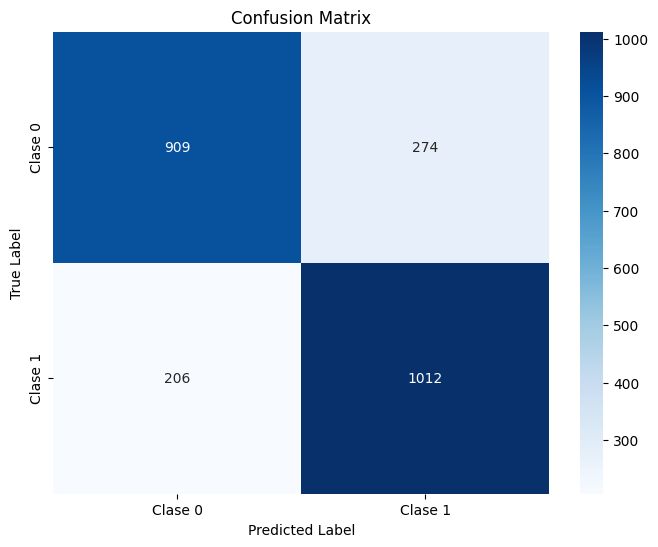

Precisión del modelo: 0.8000832986255727
Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.82      0.77      0.79      1183
        True       0.79      0.83      0.81      1218

    accuracy                           0.80      2401
   macro avg       0.80      0.80      0.80      2401
weighted avg       0.80      0.80      0.80      2401



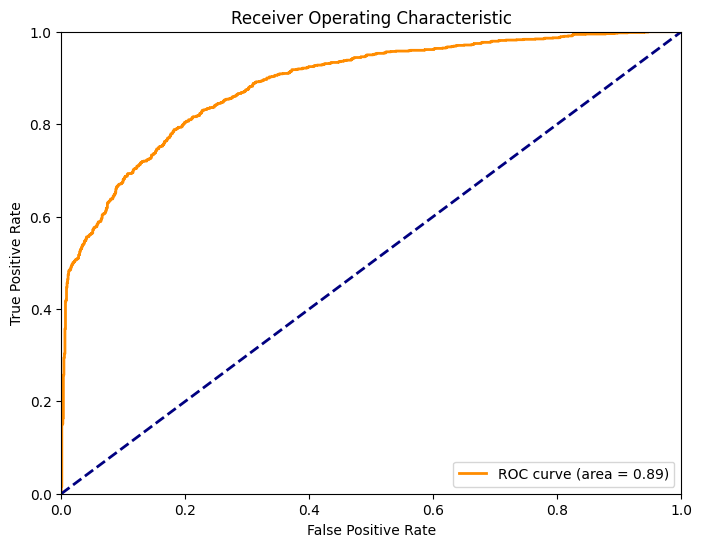

In [12]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(f"Precisión del modelo: {accuracy}")
print("Reporte de clasificación:\n", class_report)

# Calcular y graficar la curva ROC
y_prob = final_model_2.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

El ajuste parece mejor pero no mejora mucho la precisión del modelo. Podemos seguir valorando la exclusión de alguna variable pero probablemente solo consigamos bajar la precisión.

Una vez entrenado podemos aplicar el modelo a los datos

In [15]:
df_t = pd.read_csv('Test_recoded.csv')

df_test = df_t.drop(columns = ['Transported'] + columnas_no_usadas + features_eliminadas)

df_test.loc[:, 'HomePlanet'] = df_test['HomePlanet'].map({'Europa': 0, 'Earth': 1, 'Mars': 2}).astype(int)
df_test.loc[:, 'CabinDeck'] = df_test['CabinDeck'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}).astype(int)
df_test.loc[:, 'CabinSide'] = df_test['CabinSide'].map({'P': 0, 'S': 1}).astype(int)
df_test.loc[:, 'CryoSleep'] = df_test['CryoSleep'].astype(int)
df_test.loc[:, 'Destination'] = df_test['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}).astype(int)

df_test = df_test.astype(int)

prediccion = final_model_2.predict(df_test)

df_predict = pd.DataFrame({
    'PassengerId': df_t['PassengerId'],
    'Transported': prediccion.astype(bool)
})

df_predict.to_csv('prediccion_gb_nosolo.csv', index = False)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_19144\2936907257.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 1 ... 1 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_test.loc[:, 'CryoSleep'] = df_test['CryoSleep'].astype(int)


## Usando optuna para buscar hiperparametros

In [ ]:
def objective(trial):
    # Definir los hiperparámetros que queremos optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    
    # Crear el modelo con los hiperparámetros actuales
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        learning_rate=learning_rate,
        random_state=42
    )
    
    # Entrenar y evaluar el modelo usando validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    
    # Retornar la media de los puntajes de validación (queremos maximizar el accuracy)
    return cv_scores.mean()

# Crear el estudio de Optuna para encontrar los mejores hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Mostrar los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo final con los mejores hiperparámetros
final_model = GradientBoostingClassifier(
    **best_params,
    random_state=42
)

final_model.fit(X_train, y_train)

In [ ]:
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
k_folds = 5

# Realizar la validación cruzada
cv_scores = cross_val_score(final_model, X, y, cv=k_folds, scoring='accuracy')

# Mostrar los puntajes obtenidos en cada fold
print(f"Puntajes de validación cruzada (K-Fold): {cv_scores}")
print(f"Media de los puntajes de validación cruzada: {cv_scores.mean()}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(f"Precisión del modelo: {accuracy}")
print("Reporte de clasificación:\n", class_report)

# Calcular y graficar la curva ROC
y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

feature_importance = final_model.feature_importances_

# Crear un DataFrame para visualizarlo mejor (asumiendo que tienes los nombres de las características)
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Ordenar de mayor a menor importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances in GradientBoostingClassifier')
plt.gca().invert_yaxis()  # Para que las características más importantes estén en la parte superior
plt.show()